Enter City Name: pune


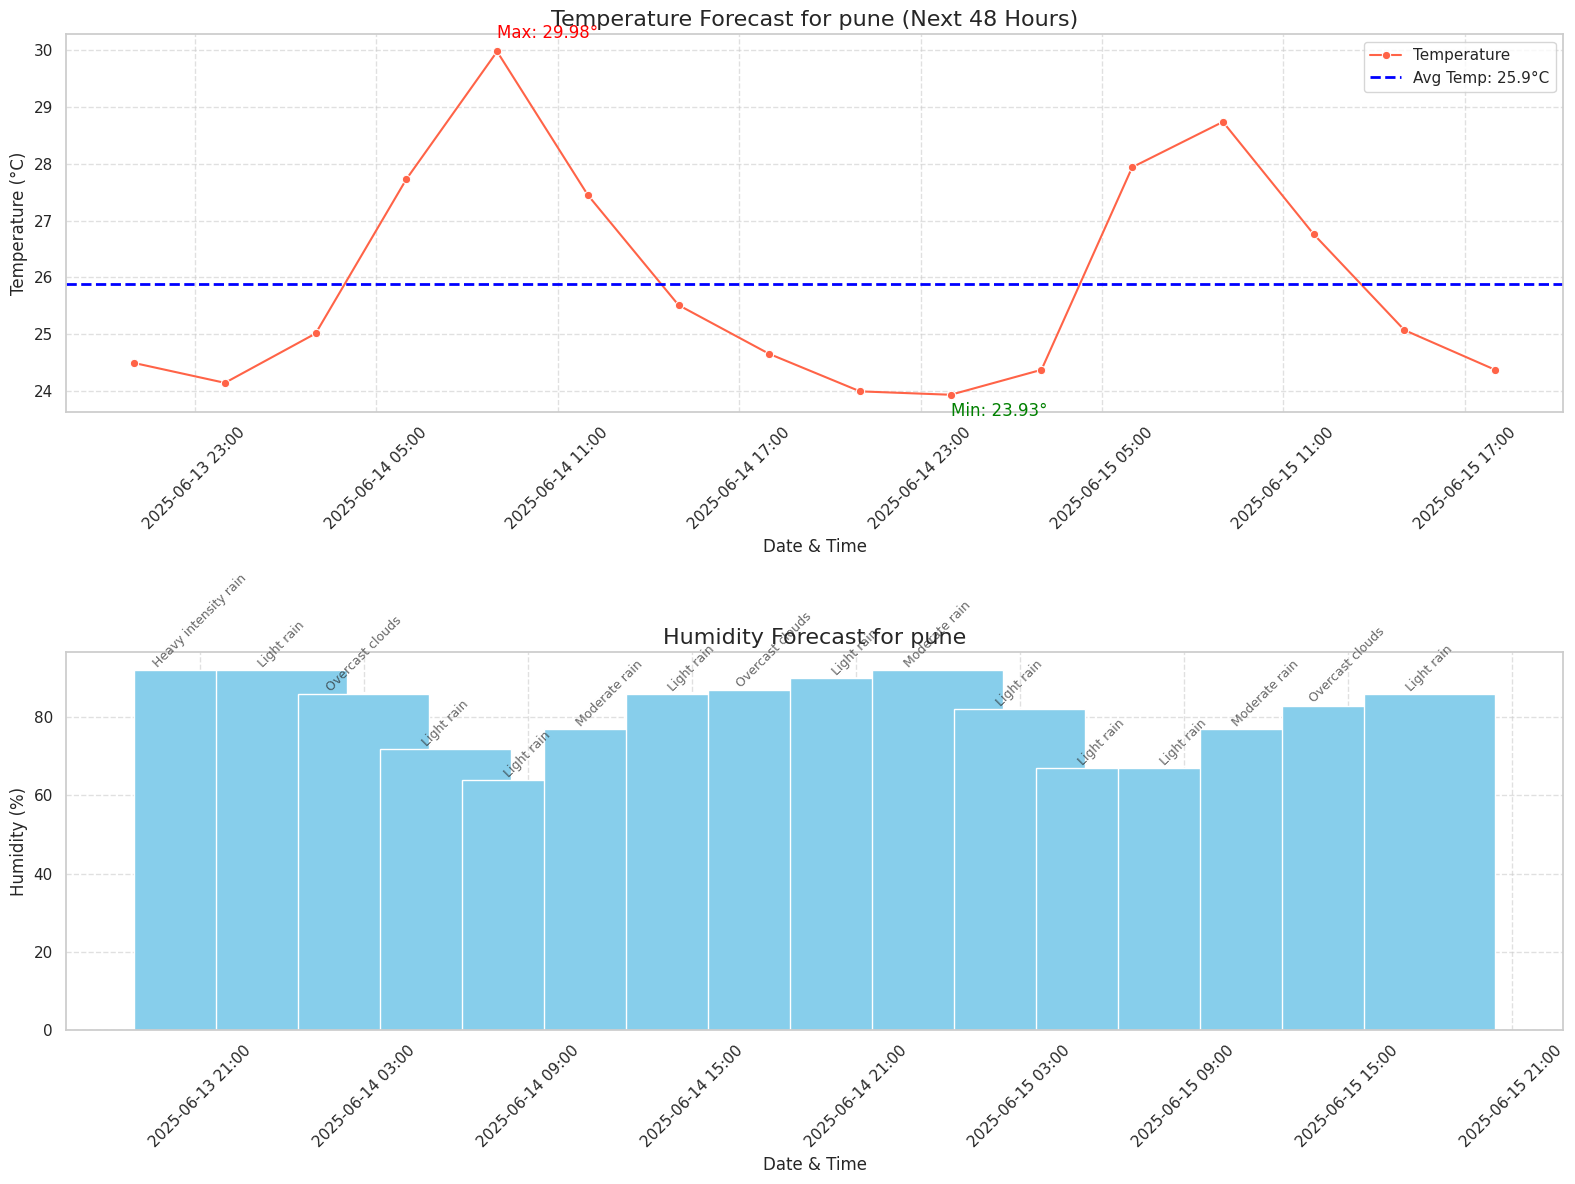

In [ ]:
# Install necessary libraries
!pip install requests seaborn matplotlib fpdf

import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fpdf import FPDF
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd

# ==== Configuration ====
API_KEY = '3643d4c7a263ce0b222497fa54e6948c'  # Use your own API key
CITY = input("Enter City Name: ").strip()
UNITS = 'metric'  # 'metric' for Celsius, 'imperial' for Fahrenheit

# ==== URL with API Key ====
URL = f'https://api.openweathermap.org/data/2.5/forecast?q={CITY}&units={UNITS}&appid={API_KEY}'

# ==== Fetch Weather Data ====
response = requests.get(URL)
if response.status_code != 200:
    print(f"❌ Failed to fetch weather data for {CITY}. Status Code: {response.status_code}")
    raise Exception("API Error")

data = response.json()

# ==== Extract Forecast Data ====
timestamps = []
temperatures = []
humidity = []
description_list = []

try:
    for entry in data['list'][:16]:  # Next 16 forecasts (~48 hours)
        timestamps.append(datetime.fromtimestamp(entry['dt']))
        temperatures.append(entry['main']['temp'])
        humidity.append(entry['main']['humidity'])
        description_list.append(entry['weather'][0]['description'].capitalize())
except KeyError as e:
    print("Unexpected data format. Missing key:", e)
    raise Exception("Data Extraction Error")

# ==== Calculate Mean Temperature ====
mean_temp = np.mean(temperatures)

# ==== Directory for Saving Images ====
os.makedirs("graphs", exist_ok=True)

# ==== Visualization ====
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=False)

# 1️⃣ Temperature Line Plot
sns.lineplot(x=timestamps, y=temperatures, ax=axes[0], marker='o', color='tomato', label="Temperature")
axes[0].axhline(mean_temp, color='blue', linestyle='--', linewidth=2, label=f"Avg Temp: {mean_temp:.1f}°C")
axes[0].set_title(f'Temperature Forecast for {CITY} (Next 48 Hours)', fontsize=16)
axes[0].set_ylabel('Temperature (°C)' if UNITS == 'metric' else 'Temperature (°F)', fontsize=12)
axes[0].set_xlabel('Date & Time', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Highlight Max & Min Points
max_temp = max(temperatures)
min_temp = min(temperatures)
max_idx = temperatures.index(max_temp)
min_idx = temperatures.index(min_temp)
axes[0].annotate(f"Max: {max_temp}°", (timestamps[max_idx], max_temp), xytext=(0, 10), textcoords='offset points', color='red')
axes[0].annotate(f"Min: {min_temp}°", (timestamps[min_idx], min_temp), xytext=(0, -15), textcoords='offset points', color='green')

# 2️⃣ Humidity Bar Plot
bars = axes[1].bar(timestamps, humidity, color='skyblue', width=0.2)
axes[1].set_title(f'Humidity Forecast for {CITY}', fontsize=16)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].set_xlabel('Date & Time', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)
for bar, desc in zip(bars, description_list):
    axes[1].annotate(desc, (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=9, rotation=45, alpha=0.7)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))

plt.tight_layout()
plt.savefig("graphs/forecast_temp_humidity.png")
plt.show()

